### Interleaver

In [28]:
import numpy as np

class CustomInterlv:
    """
    Custom Interleaver.

    Parameters
    ----------
    p_array : array-like
        Permutation array defining the interleaver.
        Must be a permutation of range(length).

    Returns
    -------
    custom_interleaver : CustomInterlv object
        A custom interleaver object.

    """
    def __init__(self, p_array):
        self.p_array = np.array(p_array, dtype=int)  # Asegúrate de que p_array sea un array de enteros
        if sorted(self.p_array) != list(range(len(p_array))):
            raise ValueError("p_array debe ser una permutación de rango(length).")
    
    def interlv(self, data):
        """Aplica la permutación a los datos."""
        return data[self.p_array]
    
    def deinterlv(self, data):
        """Aplica la permutación inversa para recuperar los datos originales."""
        inverse_p = np.argsort(self.p_array)  # Índices de la permutación inversa
        return data[inverse_p]

### Lectura de la imagen e inicializacion de variables

131328


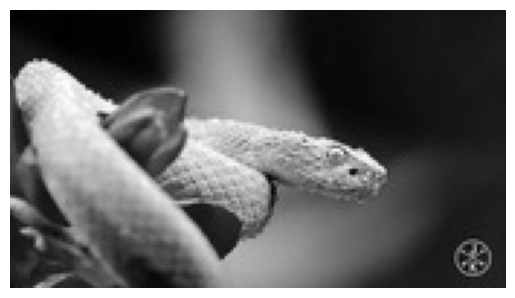

In [ ]:
import matplotlib.pyplot as plt # type: ignore
import matplotlib.image as mpimg# type: ignore
import math
from scipy import signal# type: ignore
from skimage.color import rgb2gray# type: ignore
import commpy.channelcoding as chanelcc
import random


qpsk = np.array([1+1j, -1+1j, 1-1j, -1-1j]) / np.sqrt(2)

qam16 = np.array([-3-3j, -3-1j, -3+3j, -3+1j,  
                          -1-3j, -1-1j, -1+3j, -1+1j,  
                           3-3j,  3-1j,  3+3j,  3+1j,  
                           1-3j,  1-1j,  1+3j,  1+1j]) / np.sqrt(10)

qam64 = np.array([-7-7j, -7-5j, -7-3j, -7-1j, -7+7j, -7+5j, -7+3j, -7+1j,
                          -5-7j, -5-5j, -5-3j, -5-1j, -5+7j, -5+5j, -5+3j, -5+1j,
                          -3-7j, -3-5j, -3-3j, -3-1j, -3+7j, -3+5j, -3+3j, -3+1j,
                          -1-7j, -1-5j, -1-3j, -1-1j, -1+7j, -1+5j, -1+3j, -1+1j,
                           7-7j,  7-5j,  7-3j,  7-1j,  7+7j,  7+5j,  7+3j,  7+1j,
                           5-7j,  5-5j,  5-3j,  5-1j,  5+7j,  5+5j,  5+3j,  5+1j,
                           3-7j,  3-5j,  3-3j,  3-1j,  3+7j,  3+5j,  3+3j,  3+1j,
                           1-7j,  1-5j,  1-3j,  1-1j,  1+7j,  1+5j,  1+3j,  1+1j]) / np.sqrt(42)

#Parámetros 
Modulacion = '64-QAM' #Modulacion
BW = 10 #Ancho de banda en MHz
Referencia = 4+4j
# Leer la imagen
imagena = mpimg.imread("prueba2.jpg")
imagen = rgb2gray(imagena)*255
datos_array = np.array(imagen, dtype=np.uint8)
datos = np.unpackbits(datos_array.flatten())

# Mostrar el número total de bits
# Mostrar la imagen original
print(len(datos))
plt.imshow(datos_array,cmap='gray')
plt.axis('off')
plt.show()

### Codificacion de canal

In [30]:
K = 48
resultado = []

def interleaver(K):
    interleaver_parameters = {40: [3, 10], 48: [7, 12], 56: [19, 42], 64: [7, 16], 
                              72: [7, 18], 80: [11, 20], 6144: [263, 480]}
    f1 = interleaver_parameters[K][0]
    f2 = interleaver_parameters[K][1]
    entrada = list(range(0, K))
    salida = []
    for i in range(K):
        index = (f1*i+f2*i**2) % K
        salida.append(entrada[index])
    return salida

# Representación Trellis del codificador convolucional de LTE
memory = np.array([3])
g_matrix = np.array([[1, 11]])
feedback = np.array([[13]])
trellis = chanelcc.Trellis(memory, g_matrix, feedback, 'rsc')


#inter = chanelcc.RandInterlv(10, 10)
p_array = interleaver(K)  # Permutación deseada
inter = CustomInterlv(p_array)
resultado=[]
print(len(datos)/K)
for i in range(int(len(datos)/K)):
    message_bits = datos[i * K : (i + 1) * K]    
    [coded,p1,p2] = chanelcc.turbo_encode(message_bits,trellis,trellis,inter)
    for j in range(K):
        resultado.append(coded[j])
        resultado.append(p1[j])
        resultado.append(p2[j])
print(len(datos))
print(len(resultado))

2736.0
131328
393984


### Modulacion QPSK, 16-QAM, 64-QAM

In [ ]:
def generarSimbolos(datos, modulacion):
    longitud = len(datos)
    
    if modulacion == 'QPSK':
        # 2 bits por símbolo
        datos = np.array(datos).reshape(-1, 2)
        indices = datos.dot(1 << np.arange(2)[::-1])  # Mapea los bits a índices
        simbolos = qpsk[indices]

    elif modulacion == '16-QAM':
        # 4 bits por símbolo
        datos = np.array(datos).reshape(-1, 4)
        indices = datos.dot(1 << np.arange(4)[::-1])  # Mapea los bits a índices
        simbolos = qam16[indices]

    elif modulacion == '64-QAM':
        # 6 bits por símbolo
        datos = np.array(datos).reshape(-1, 6)
        indices = datos.dot(1 << np.arange(6)[::-1])  # Mapea los bits a índices
        simbolos = qam64[indices]

    else: 
        raise Exception('Solo de QPSK a 64QAM.')
    
    return simbolos

nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = generarSimbolos(resultado,Modulacion)
print(len(modulado))
for i in range(6,nSubportadoras,12):
    modulado = np.insert(modulado, i, Referencia)

nSimbolos = len(modulado)
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)
print('Número de bloques de recursos:',nBloques)
print('Número de subportadoras:',nSubportadoras)
print('Número de símbolos a enviar:',nSimbolos)
print('Número de símbolos OFDM:',nSimbolosOFDM)

65664
Número de bloques de recursos: 56
Número de subportadoras: 672
Número de símbolos a enviar: 65720
Número de símbolos OFDM: 98


### Modulacion OFDM

In [32]:
#Modulacion OFDM
N = 2**math.ceil(math.log2(nSubportadoras))
print(N)


datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM


for i in range(nSimbolosOFDM):
    scArray = np.zeros(N, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(modulado[j:j+nSubportadoras])
        if longitud < nSubportadoras:
            scArray[0:nSubportadoras] = np.concatenate((modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
        else:
            scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    else:
        scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    # Realizar la modulación IFFT
    datosOFDMsr = np.fft.ifft(scArray, N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
    datosOFDM[k:k + N] = datosOFDMsr
    # Incrementar los índices
    j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
    k = k + N  # Incrementar el índice para los datos OFDM




1024


### Prefijo ciclico

In [33]:
# Define la función para agregar el prefijo cíclico (CP)
def anadirPrefijo(simboloOfdm, N, longitudCP):
    # Extraer el CP (las últimas longitudCP muestras del símbolo OFDM)
    cp = simboloOfdm[N - longitudCP:N:1]
    
    # Concatenar el CP y el símbolo OFDM
    simboloOfdm_cp = np.concatenate((cp, simboloOfdm))
    
    return simboloOfdm_cp

longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
j = 0
k = 0
for i in range(nSimbolosOFDM):
    # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
    ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[j:j + N], N, longitudCP)
    
    # Incrementar los índices para la siguiente iteración
    j = j + N
    k = k + N + longitudCP


#plt.figure(figsize=(15, 4))
#plt.plot(Papr,'b')
#plt.title('PAPR de los símbolos enviados')
#plt.xlabel('Símbolo')
#plt.ylabel('Magnitud')
#plt.show()


### Efectos del canal

In [42]:
#Efectos del canal
# Parámetros del canal de multicamino

nCaminos = 4
h = np.random.randn(nCaminos) + np.random.randn(nCaminos)*1j
# Aplicar filtro del canal 
canal = np.fft.fft(h,N)

Senal_mp = np.convolve(ofdmConCP,h)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]

#Efecto de canal AWGN
SNR = 25 # Desired SNR (dB) 
def awgn(senal,SNR):
    # Measure signal power 
    potenciaSenal = np.mean(abs(senal)**2)

    # Calculate noise power 
    potenciaRuido = potenciaSenal/(10 **(SNR/10))
    
    # Generate complex noise 
    noise = np.sqrt(potenciaRuido/2)*(np.random.randn(len(senal)) + np.random.randn(len(senal))*1j)
    
    # Add signal and noise 
    senalRuidosa = senal + noise 
    
    return senalRuidosa #,potenciaRuido
#[SenalRx,Varianza] = awgn(Senal_mp,SNR)
#SenalRx = awgn(ofdmConCP,SNR)
SenalRx = awgn(Senal_mp,SNR)
#SenalRx = Senal_mp
#SenalRx = ofdmConCP
len(SenalRx)

36201

### Demodulacion OFDM

21888
1024
21888


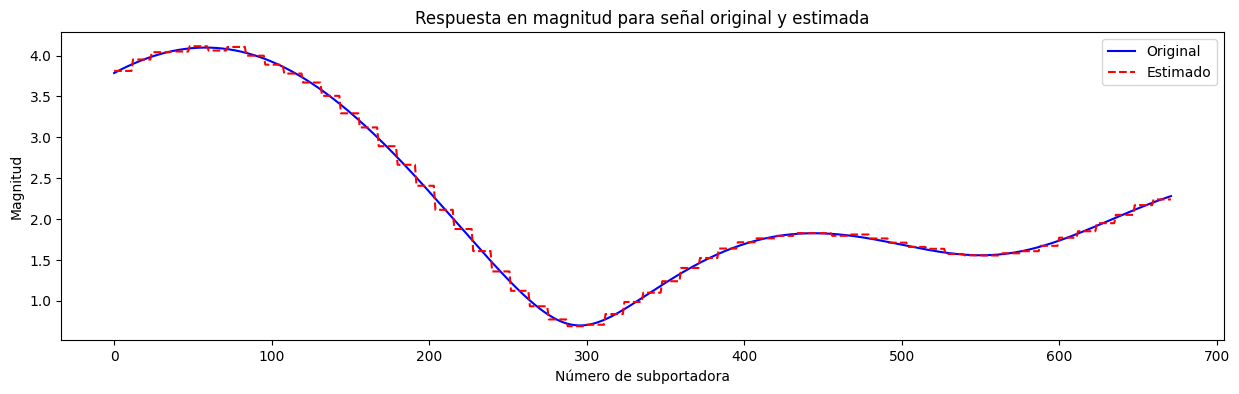

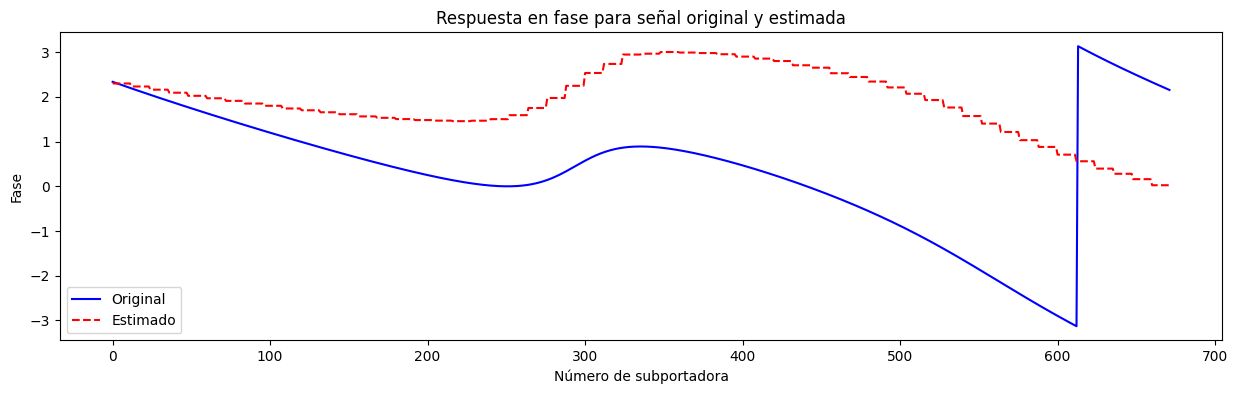

In [43]:
#Demodulacion OFDM
def demodulacionOFDM(ofdmRx, N, longitudCP):
    # Remover el CP (Prefijo Cíclico) de los símbolos OFDM recibidos
    ofdmSinPrefijo = ofdmRx[longitudCP:(N + longitudCP)]
    
    # Realizar la Transformada Rápida de Fourier (FFT) sobre los símbolos OFDM sin CP
    # fftshift se utiliza para centrar la frecuencia 0 en el centro del espectro
    data = np.fft.fft(ofdmSinPrefijo, N)
    return data

# Array para almacenar los símbolos de datos recuperados
rxDatos = np.zeros(nSimbolos-nBloques, np.complex64)
estimado_rx = []
j = 0
k = 0 
x = 0
# Extraer el contenido de datos (después del final del L-LTF)
L = len(SenalRx)
print(len(rxDatos))
Referencias_rx = []
# Demodular los símbolos OFDM en el contenido de datos
for i in range(nSimbolosOFDM):
    rx_demod = demodulacionOFDM(SenalRx[k:(k + N + longitudCP)], N, longitudCP)
    if i == 0:
        for l in range(len(rx_demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(rx_demod[l])
                x += 1
            else:
                rxDatos[l-x]=rx_demod[l]
        print(len(rx_demod))
        j = j + nSubportadoras - nBloques
        for l in range(nSubportadoras):
            estimado_rx.append(Referencias_rx[l//12])
        estimacion_canal = np.array(estimado_rx)/(Referencia)
    else:
        if i == (nSimbolosOFDM-1):
            rxDatos[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos)-j)]/estimacion_canal[0:(len(rxDatos)-j)]
        else:
            rxDatos[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]/estimacion_canal
    
    # Actualizar los índices para la siguiente iteración
        j = j + nSubportadoras
    k = k + N + longitudCP
print(len(rxDatos))
# Respuesta en magnitud
plt.figure(figsize=(15, 4))
plt.plot(abs(canal)[0:nSubportadoras],'b')
plt.plot(abs(estimacion_canal),'--r')
plt.title('Respuesta en magnitud para señal original y estimada')
plt.xlabel('Número de subportadora')
plt.ylabel('Magnitud')
plt.legend(('Original','Estimado'))
plt.show()
# Respuesta en fase
plt.figure(figsize=(15, 4))
plt.plot(np.angle(canal)[0:nSubportadoras],'b')
plt.plot(np.angle(estimacion_canal),'--r')
plt.title('Respuesta en fase para señal original y estimada')
plt.xlabel('Número de subportadora')
plt.ylabel('Fase')
plt.legend(('Original','Estimado'))
plt.show()



### Demodulacion QPSK, 16-QAM, 64-QAM

In [ ]:
constelaciones = {
    'QPSK': qpsk,
    '16-QAM': qam16,
    '64-QAM': qam64
}


def decision_vectorizada(modulado, matriz):
    # Calcular todas las distancias en una sola operación vectorizada
    distancias = np.abs(modulado[:, np.newaxis] - matriz)  # Broadcasting para calcular distancias
    indices = np.argmin(distancias, axis=1)  # Encuentra los índices de las distancias mínimas
    # Convertir los índices a binario de forma vectorizada
    bits = np.array([list(np.binary_repr(i, width=int(np.log2(len(matriz))))) for i in indices], dtype=int)
    return bits.flatten()  # Devolver como un solo vector plano

if Modulacion not in constelaciones:
    raise Exception('Modulation method must be QPSK, 16-QAM, or 64-QAM.')

# Selección de la constelación de acuerdo al tipo de modulación
constelacion = constelaciones[Modulacion]

# Aplicar la función de decisión a todos los valores modulados de una vez
dataSombrero = decision_vectorizada(rxDatos, constelacion)
print(len(rxDatos))
print(len(dataSombrero))

65664
393984


### Decodificacion de canal

In [37]:
#Decodificación de canal
resultado2=[]
cod = []
p_1 = []
p_2 = []
print(len(dataSombrero))
for i in range(int(len(dataSombrero)/3)):
    cod.append(int(dataSombrero[i*3]))
    p_1.append(int(dataSombrero[(i*3)+1]))
    p_2.append(int(dataSombrero[(i*3)+2]))
print(len(cod)/K)
print(len(p_1))
print(len(p_2))

for i in range(int(len(datos)/K)):
    if i%500 == 0:
        print(i)
    coded = np.array(cod[i*K:(i+1)*K])
    p1 = np.array(p_1[i*K:(i+1)*K])
    p2 = np.array(p_2[i*K:(i+1)*K])
    decoded_bits = chanelcc.turbo_decode(coded,p1,p2,trellis,0.1,4,inter)

    # Concatenar los resultados
    for k in range(K):
       resultado2.append(decoded_bits[k])

393984
2736.0
131328
131328
0
500
1000
1500
2000
2500


In [38]:
nBloques = math.ceil(BW/0.18)
nSubportadoras = nBloques * 12
modulado = generarSimbolos(datos,Modulacion)
print(len(modulado))
for i in range(6,nSubportadoras,12):
    modulado = np.insert(modulado, i, Referencia)

nSimbolos = len(modulado)
nSimbolosOFDM = math.ceil(nSimbolos/nSubportadoras)

#Modulacion OFDM
N = 2**math.ceil(math.log2(nSubportadoras))
print(N)


datosOFDM = np.zeros(nSimbolosOFDM * N, np.complex64)  # Array para almacenar los símbolos OFDM, inicializado con ceros y de tipo complejo
j = 0  # Índice para los datos de entrada
k = 0  # Índice para los datos OFDM


for i in range(nSimbolosOFDM):
    scArray = np.zeros(N, np.complex64)
    if i == (nSimbolosOFDM-1):
        longitud=len(modulado[j:j+nSubportadoras])
        if longitud < nSubportadoras:
            scArray[0:nSubportadoras] = np.concatenate((modulado[j:j+nSubportadoras],np.zeros(nSubportadoras-longitud)))
        else:
            scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    else:
        scArray[0:nSubportadoras] = modulado[j:j+nSubportadoras]
    # Realizar la modulación IFFT
    datosOFDMsr = np.fft.ifft(scArray, N)  # Aplicar IFFT para convertir los datos al dominio del tiempo
    datosOFDM[k:k + N] = datosOFDMsr
    # Incrementar los índices
    j = j + nSubportadoras  # Incrementar el índice para los datos de entrada
    k = k + N  # Incrementar el índice para los datos OFDM

longitudCP = math.ceil((N/66.666666)*4.7)
#longitudCP = 0

# Agregar el CP a cada uno de los símbolos OFDM
ofdmConCP = np.zeros(nSimbolosOFDM * (N + longitudCP), np.complex64)  # Inicializar un array para los datos OFDM con CP
j = 0
k = 0
for i in range(nSimbolosOFDM):
    # Llamar a la función anadirPrefijo para agregar el CP al símbolo OFDM y almacenarlo en el array ofdmConCP
    ofdmConCP[k:(k + N + longitudCP)] = anadirPrefijo(datosOFDM[j:j + N], N, longitudCP)
    
    # Incrementar los índices para la siguiente iteración
    j = j + N
    k = k + N + longitudCP
    
Senal_mp = np.convolve(ofdmConCP,h)[int((nCaminos-1)/2):-math.ceil((nCaminos-1)/2)]
SenalRx = awgn(Senal_mp,SNR)

rxDatos = np.zeros(nSimbolos-nBloques, np.complex64)
estimado_rx = []
j = 0
k = 0 
x = 0
# Extraer el contenido de datos (después del final del L-LTF)
L = len(SenalRx)
print(len(rxDatos))
Referencias_rx = []
# Demodular los símbolos OFDM en el contenido de datos
for i in range(nSimbolosOFDM):
    rx_demod = demodulacionOFDM(SenalRx[k:(k + N + longitudCP)], N, longitudCP)
    if i == 0:
        for l in range(len(rx_demod)):
            if l%12 == 6:
                if l <= nSubportadoras:
                    Referencias_rx.append(rx_demod[l])
                x += 1
            else:
                rxDatos[l-x]=rx_demod[l]
        print(len(rx_demod))
        j = j + nSubportadoras - nBloques
        for l in range(nSubportadoras):
            estimado_rx.append(Referencias_rx[l//12])
        estimacion_canal = np.array(estimado_rx)/(Referencia)
    else:
        if i == (nSimbolosOFDM-1):
            rxDatos[j:j + nSubportadoras] = rx_demod[0:(len(rxDatos)-j)]/estimacion_canal[0:(len(rxDatos)-j)]
        else:
            rxDatos[j:j + nSubportadoras] = rx_demod[0:nSubportadoras]/estimacion_canal
    
    # Actualizar los índices para la siguiente iteración
        j = j + nSubportadoras
    k = k + N + longitudCP

dataSombrero2 = decision_vectorizada(rxDatos, constelacion)

21888
1024
21888
1024


131328


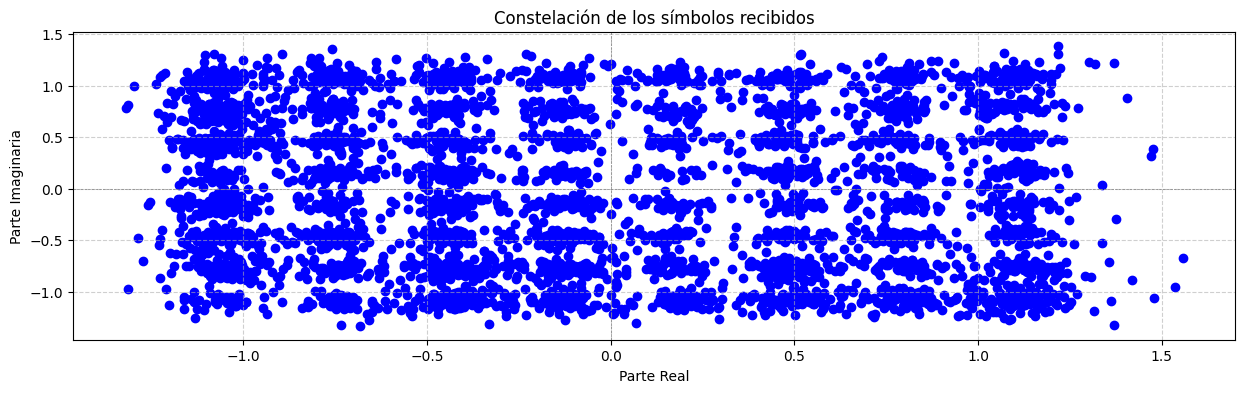

In [39]:
grafica = rxDatos[5000:10000]
print(len(resultado2))
plt.figure(figsize=(15, 4))  # Cuadrar para que sea proporcional
plt.scatter(grafica.real, grafica.imag, color='blue')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.title('Constelación de los símbolos recibidos')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

### Calculo BER

In [40]:
def calcular_BER(bits_reales, bits_recibidos):
    if len(bits_reales) != len(bits_recibidos):
        raise ValueError("Los vectores deben tener la misma longitud.")
    
    # Calcular el número de bits en error
    errores = np.sum(bits_reales != bits_recibidos)
    
    # Calcular la Tasa de Error de Bit (BER)
    ber = errores / len(bits_reales)
    return ber
print(len(datos))
print("BER:",calcular_BER(datos,resultado2))
print("BER:",calcular_BER(datos,dataSombrero2))

131328
BER: 0.002139680799220273
BER: 0.03296326754385965


### Imagen recibida

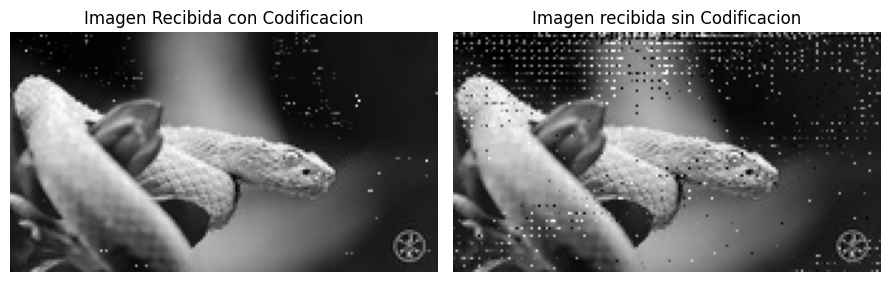

In [47]:
#Grafica recibida
datos_rx = resultado2
datos_rx2 = dataSombrero2

bits_array = np.array(datos_rx, dtype=np.uint8)
num_bytes = bits_array.size // 8  # Cantidad de bytes necesarios
bytes_array = bits_array[:num_bytes * 8].reshape(-1, 8)

bits_array2 = np.array(datos_rx2, dtype=np.uint8)
num_bytes2 = bits_array2.size // 8  # Cantidad de bytes necesarios
bytes_array2 = bits_array2[:num_bytes2 * 8].reshape(-1, 8)

# Convertir los grupos de 8 bits en valores enteros de 0 a 255 (uint8)
pixels_array = np.packbits(bytes_array)
pixels_array2 = np.packbits(bytes_array2)

# Reconstruir la imagen a partir de los píxeles
# Primero, debemos saber la forma original de la imagen
dimension_original = (96, 171)  # Asegúrate de usar las dimensiones correctas
imagen_recuperada = pixels_array.reshape(dimension_original)
imagen_recuperada2 = pixels_array2.reshape(dimension_original)

# Mostrar la imagen recuperada
fig, axes = plt.subplots(1, 2, figsize=(9, 4))

# Gráfica 1
axes[0].imshow(imagen_recuperada, cmap='gray')
axes[0].axis('off')
axes[0].set_title('Imagen Recibida con Codificacion')

# Gráfica 2
axes[1].imshow(imagen_recuperada2, cmap='gray')
axes[1].axis('off')
axes[1].set_title('Imagen recibida sin Codificacion')

# Mostrar ambas gráficas
plt.tight_layout()
plt.show()